In [94]:
!nvidia-smi

Fri Dec  1 00:01:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0   227W / 300W |  14288MiB / 16384MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

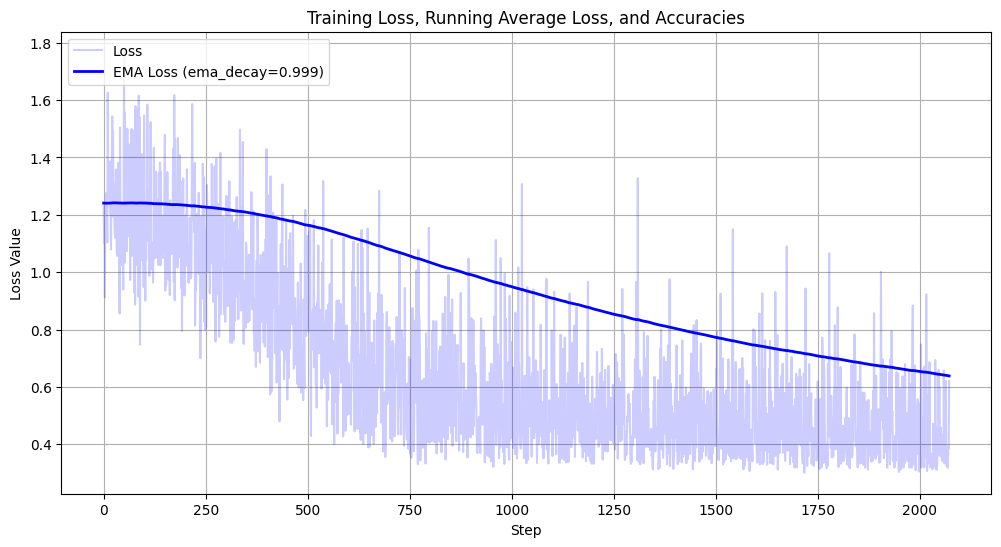

In [176]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def calculate_ema(values, alpha):
    ema_values = []
    ema = np.mean(values[:100])
    for value in values:
        ema = alpha * ema + (1 - alpha) * value
        ema_values.append(ema)
    return ema_values

# Adjusted patterns to match the new log format
loss_pattern = re.compile(r'\[\d+, +(\d+)\] loss: ([\d.]+)')
accuracy_pattern = re.compile(r'TMA Accuracy: ([\d.]+) \| Non-TMA Accuracy: ([\d.]+) \| Overall Accuracy: ([\d.]+)')

# Lists to store the extracted data
steps = []
losses = []
tma_accuracies = []
non_tma_accuracies = []
overall_accuracies = []
accuracy_steps = []

last_step = None

# Reading the file contents
file_path = 'logs/even-more-balanced.txt'  # Replace with the path to your file
with open(file_path, 'r') as file:
    training_log = file.readlines()

# Parsing the file
for line in training_log:
    # Extracting loss and step
    loss_match = loss_pattern.match(line)
    if loss_match:
        step, loss = map(float, loss_match.groups())
        steps.append(step)
        losses.append(loss)
        last_step = step

    # Extracting accuracies
    accuracy_match = accuracy_pattern.match(line)
    if accuracy_match and last_step is not None:
        tma_accuracy, non_tma_accuracy, overall_accuracy = map(float, accuracy_match.groups())
        tma_accuracies.append(tma_accuracy)
        non_tma_accuracies.append(non_tma_accuracy)
        overall_accuracies.append(overall_accuracy)
        accuracy_steps.append(last_step)

# Creating DataFrames
loss_data = pd.DataFrame({
    'Step': steps,
    'Loss': losses
})
accuracy_data = pd.DataFrame({
    'Step': accuracy_steps,
    'TMA Accuracy': tma_accuracies,
    'Non-TMA Accuracy': non_tma_accuracies,
    'Overall Accuracy': overall_accuracies
})

# Calculating EMA loss
ema_decay = 0.999  # decay factor for EMA
loss_data['EMA Loss'] = calculate_ema(loss_data['Loss'], ema_decay)

# Merging the loss and accuracy data
merged_data = pd.merge(loss_data, accuracy_data, on='Step', how='left')
merged_data.fillna(method='ffill', inplace=True)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Loss and Running Average Loss
ax1.plot(merged_data['Step'], merged_data['Loss'], label='Loss', alpha=0.2, color='blue')
ax1.plot(merged_data['Step'], merged_data['EMA Loss'], label=f'EMA Loss (ema_decay={ema_decay})', linewidth=2, color='blue')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss Value')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Title
plt.title('Training Loss, Running Average Loss, and Accuracies')

# Display the plot
plt.show()

In [177]:
loss_data

,Step,Loss,EMA Loss
0,0.0,1.236,1.241045
1,1.0,1.102,1.240906
2,2.0,1.205,1.240870
3,3.0,0.913,1.240542
4,4.0,1.207,1.240509
...,...,...,...
2068,2068.0,0.321,0.639355
2069,2069.0,0.318,0.639033
2070,2070.0,0.391,0.638785
2071,2071.0,0.387,0.638533


In [178]:
loss_data['Loss'].iloc[-100:].mean()

0.44734

In [179]:
loss_data['EMA Loss'].idxmin(), loss_data['EMA Loss'].min()

(2072, 0.6385158033393455)